In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Subset
from torch.optim import SGD
from torch.optim import Optimizer
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Data Loading and Augmentation
image_size = 224
train_path = "/teamspace/studios/this_studio/Animal Classification Capstone Project (2)/DeepLearning/DeepLearning 24-25/Train"

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((image_size+20, image_size+20)),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1))
])

val_test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [5]:
# Load dataset with basic transform
raw_dataset = datasets.ImageFolder(root=train_path)

# Split dataset
train_size = int(0.8 * len(raw_dataset))
val_size = len(raw_dataset) - train_size
train_indices, val_indices = random_split(range(len(raw_dataset)), [train_size, val_size])

In [6]:
class ApplyTransform(torch.utils.data.Dataset):
    """Apply different transforms to different subsets"""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [7]:
train_dataset = ApplyTransform(Subset(raw_dataset, train_indices.indices), train_transform)
val_dataset = ApplyTransform(Subset(raw_dataset, val_indices.indices), val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
class SAM(Optimizer):
    """Sharpness-Aware Minimization (SAM) optimizer wrapper"""
    def __init__(self, base_optimizer, rho=0.05):
        assert isinstance(base_optimizer, Optimizer), "SAM needs a base optimizer"
        params = base_optimizer.param_groups
        super().__init__(params, dict(rho=rho))
        self.base_optimizer = base_optimizer
        self.param_groups = base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)
            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                p.add_(p.grad * scale)
        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None or "old_p" not in self.state[p]: continue
                p.data = self.state[p]["old_p"]
        self.base_optimizer.step()
        if zero_grad: self.zero_grad()

    def _grad_norm(self):
        norm = torch.norm(
            torch.stack([p.grad.norm(p=2) for group in self.param_groups for p in group["params"] if p.grad is not None]),
            p=2
        )
        return norm

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = nn.ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = nn.ReLU()(out)
        return out

class CustomCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



In [10]:
model = CustomCNN(num_classes=7, dropout_rate=0.6).to(device)

# Replace AdamW with SGD with Lookahead
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True)

# Use Cosine Annealing with Warm Restarts
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-5)

# Add Gradient Clipping
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

# Use Label Smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [11]:

model = CustomCNN(num_classes=7, dropout_rate=0.6).to(device)
# Wrap base optimizer with SAM
# Optimizer with lower initial learning rate
base_optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
optimizer = SAM(base_optimizer, rho=0.02)  # Reduced rho for SAM

def warmup_scheduler(optimizer, current_step, warmup_steps=500):
    if current_step < warmup_steps:
        lr_scale = float(current_step) / float(warmup_steps)
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.01 * lr_scale

# Modified criterion
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # Reduced label smoothing

In [12]:
def validate(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return val_loss/len(loader), 100*correct/total

In [40]:
best_val_acc = 0
patience = 15
warmup_steps = 500
current_step = 0

for epoch in range(100):
    model.train()
    train_loss = 0.0
    
    # Learning rate warmup
    warmup_scheduler(optimizer, current_step, warmup_steps)
    
    for images, labels in train_loader:
        current_step += 1
        images, labels = images.to(device), labels.to(device)
        
        # Moderate Mixup
        inputs, targets_a, targets_b, lam = mixup_data(images, labels, alpha=0.2)
        
        # SAM steps
        def closure():
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            loss.backward()
            return loss
        
        loss = closure()
        train_loss += loss.item()
        optimizer.first_step(zero_grad=True)
        
        closure()
        optimizer.second_step(zero_grad=True)
    
    avg_train_loss = train_loss / len(train_loader)
    
    # Validation
    model.eval()
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'improved_model.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

Epoch 1: Train Loss: 1.9656, Val Acc: 15.03%
Current LR: 0.000000
Epoch 2: Train Loss: 1.8941, Val Acc: 33.61%
Current LR: 0.001200
Epoch 3: Train Loss: 1.7748, Val Acc: 36.53%
Current LR: 0.002400
Epoch 4: Train Loss: 1.7031, Val Acc: 40.08%
Current LR: 0.003600
Epoch 5: Train Loss: 1.6776, Val Acc: 42.17%
Current LR: 0.004800
Epoch 6: Train Loss: 1.6405, Val Acc: 42.38%
Current LR: 0.006000
Epoch 7: Train Loss: 1.6539, Val Acc: 46.35%
Current LR: 0.007200
Epoch 8: Train Loss: 1.6018, Val Acc: 47.60%
Current LR: 0.008400
Epoch 9: Train Loss: 1.6234, Val Acc: 48.43%
Current LR: 0.009600
Epoch 10: Train Loss: 1.5943, Val Acc: 45.51%
Current LR: 0.009600
Epoch 11: Train Loss: 1.5990, Val Acc: 48.43%
Current LR: 0.009600
Epoch 12: Train Loss: 1.5770, Val Acc: 52.82%
Current LR: 0.009600
Epoch 13: Train Loss: 1.5484, Val Acc: 48.23%
Current LR: 0.009600
Epoch 14: Train Loss: 1.5722, Val Acc: 51.77%
Current LR: 0.009600
Epoch 15: Train Loss: 1.5115, Val Acc: 48.23%
Current LR: 0.009600
Epoc


Final Test Results:
Test Loss: 0.4731
Test Accuracy: 80.00%
Precision: 0.8041
Recall: 0.8000
F1-Score: 0.7977


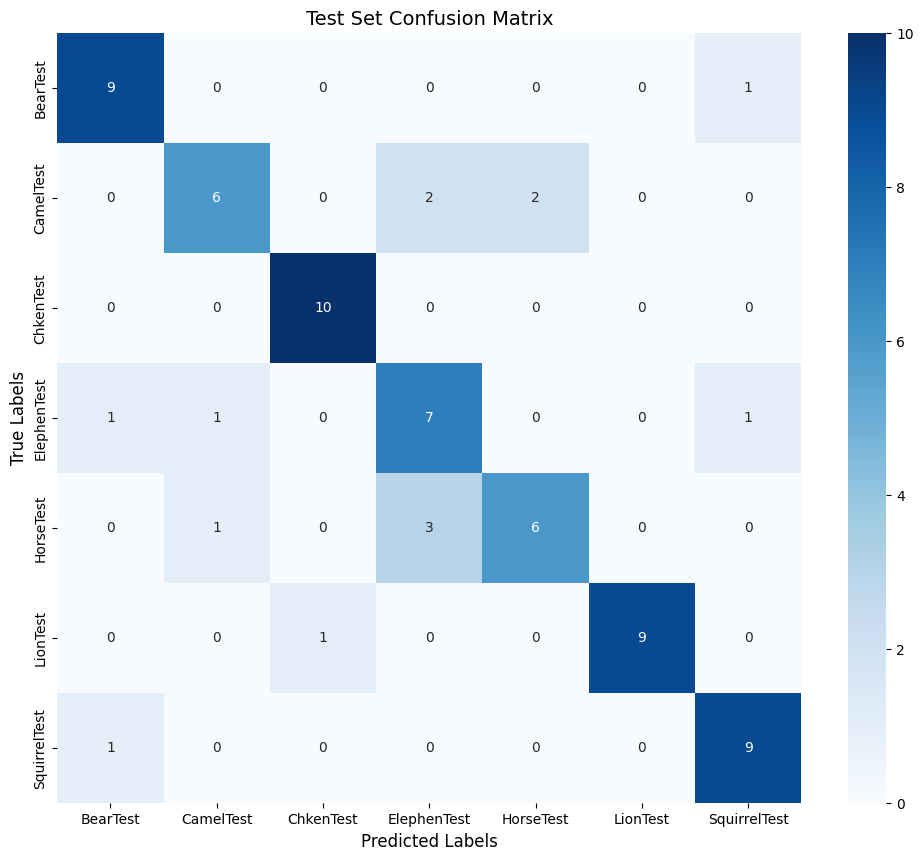


Class-wise Accuracy:
BearTest       : 90.00%
CamelTest      : 60.00%
ChkenTest      : 100.00%
ElephenTest    : 70.00%
HorseTest      : 60.00%
LionTest       : 90.00%
SquirrelTest   : 90.00%


In [13]:
def validate(model, loader, criterion):
    """Integrated validation function matching training structure"""
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return val_loss/len(loader), 100*correct/total

# Enhanced Evaluation function with additional metrics
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = running_loss / len(loader)
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    
    return avg_loss, accuracy, precision, recall, f1, cm

# Test dataset and loader
test_path = "/teamspace/studios/this_studio/Animal Classification Capstone Project (2)/DeepLearning/DeepLearning 24-25/Test"
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(root=test_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load best model with proper initialization
model = CustomCNN(num_classes=7, dropout_rate=0.5).to(device)  # Match training config
try:
    model.load_state_dict(torch.load("improved_model.pth"))
except RuntimeError as e:
    print("Model architecture mismatch! Ensure CustomCNN matches training configuration")
    raise e

model.eval()

# Evaluate with same criterion as validation
test_criterion = nn.CrossEntropyLoss()
test_loss, test_acc, test_precision, test_recall, test_f1, test_cm = evaluate_model(model, test_loader, test_criterion)

# Print comprehensive results
print("\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.classes, 
            yticklabels=test_dataset.classes)
plt.title('Test Set Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.show()

# Class-wise metrics
class_acc = {}
for i, class_name in enumerate(test_dataset.classes):
    acc = 100 * test_cm[i,i] / test_cm[i].sum()
    class_acc[class_name] = acc

print("\nClass-wise Accuracy:")
for class_name, acc in class_acc.items():
    print(f"{class_name:15s}: {acc:.2f}%")


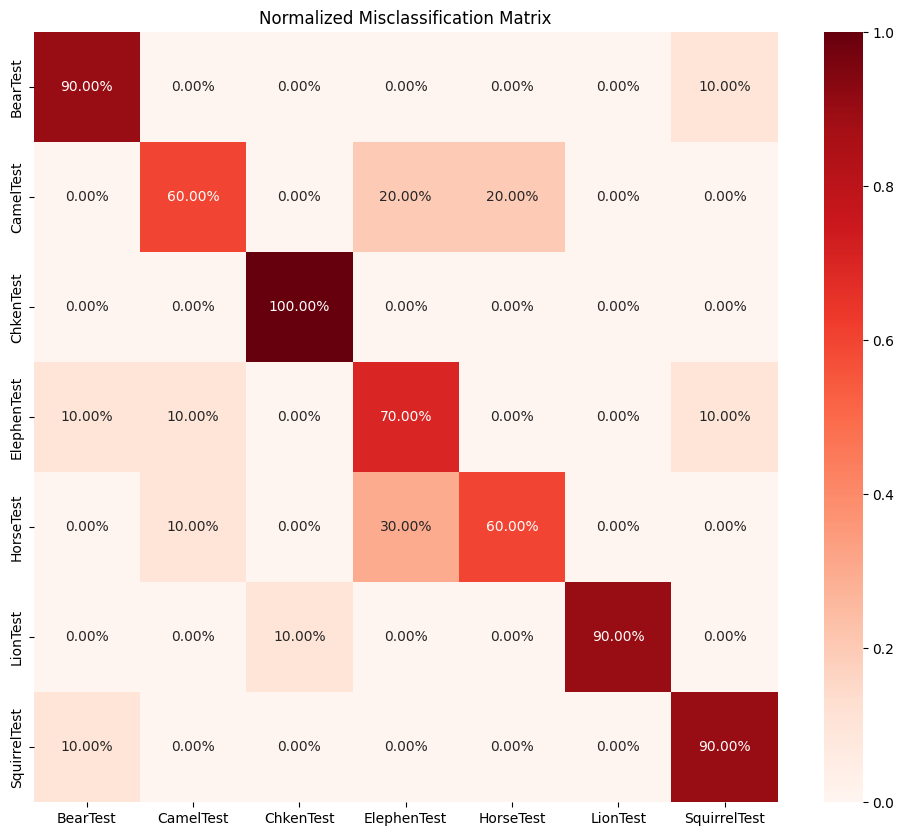

In [14]:
# Generate detailed confusion matrix analysis
class_names = test_dataset.classes
misclassification_matrix = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(misclassification_matrix, annot=True, fmt=".2%", cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Misclassification Matrix')
plt.show()

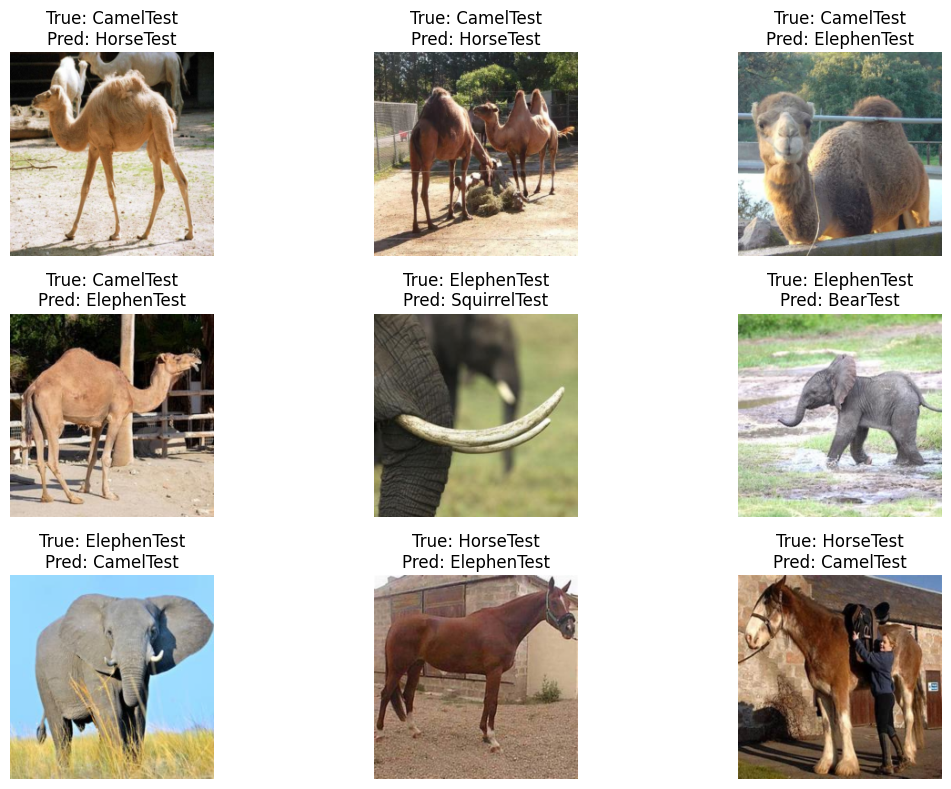

In [15]:
# Collect misclassified samples
misclassified_samples = []
for i, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    for j in range(images.size(0)):
        if preds[j] != labels[j] and labels[j] in [class_names.index(c) for c in ['ElephenTest', 'HorseTest', 'CamelTest']]:
            misclassified_samples.append({
                'image': images[j].cpu(),
                'true': class_names[labels[j]],
                'pred': class_names[preds[j]]
            })
            if len(misclassified_samples) >= 9: break
    if len(misclassified_samples) >= 9: break

# Visualize misclassifications
plt.figure(figsize=(12, 8))
for i, sample in enumerate(misclassified_samples[:9]):
    plt.subplot(3, 3, i+1)
    img = sample['image'].permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    plt.imshow(np.clip(img, 0, 1))
    plt.title(f"True: {sample['true']}\nPred: {sample['pred']}")
    plt.axis('off')
plt.tight_layout()
plt.show()

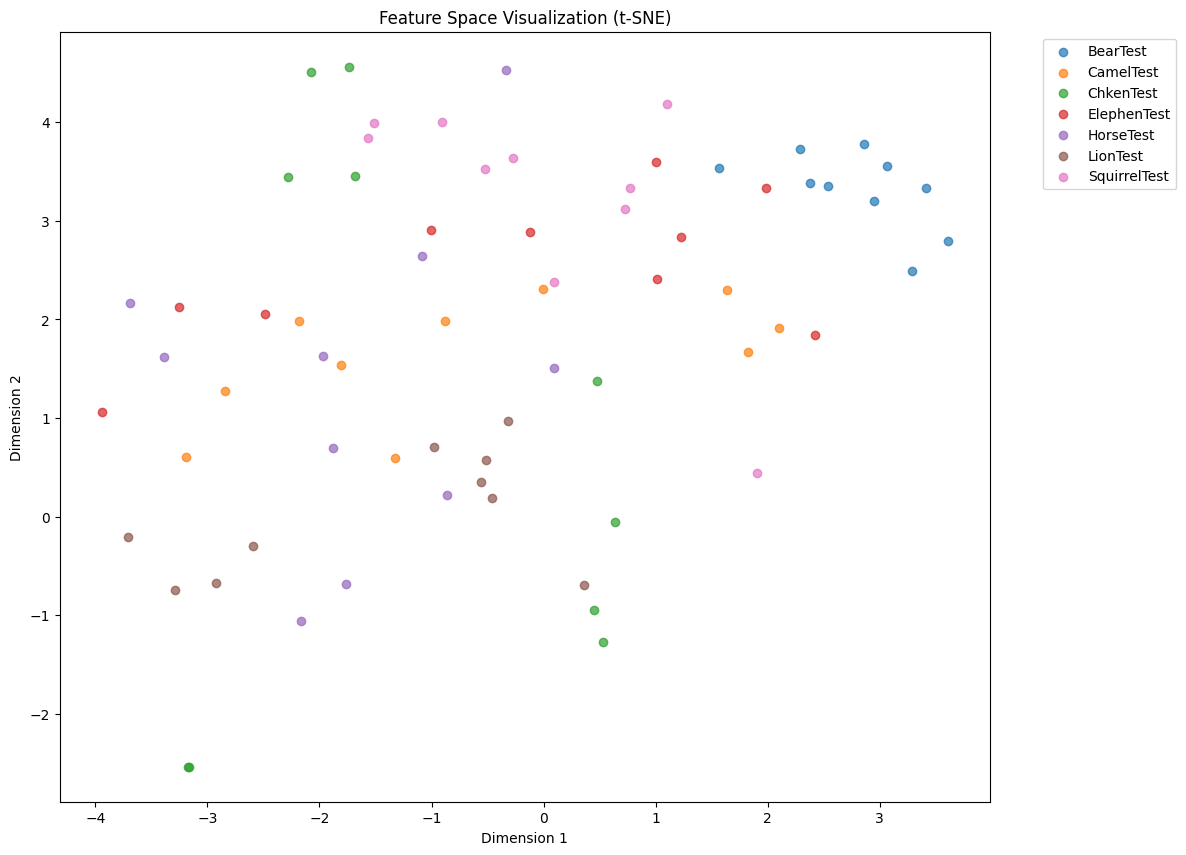

In [16]:
from sklearn.manifold import TSNE

# Extract features
model.eval()
features = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        feats = model.features(images).view(images.size(0), -1)
        features.append(feats.cpu())
        true_labels.append(labels)

features = torch.cat(features).numpy()
true_labels = torch.cat(true_labels).numpy()

# T-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(12, 10))
for i, class_name in enumerate(test_dataset.classes):
    idx = np.where(true_labels == i)
    plt.scatter(features_2d[idx, 0], features_2d[idx, 1], label=class_name, alpha=0.7)
    
plt.title('Feature Space Visualization (t-SNE)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

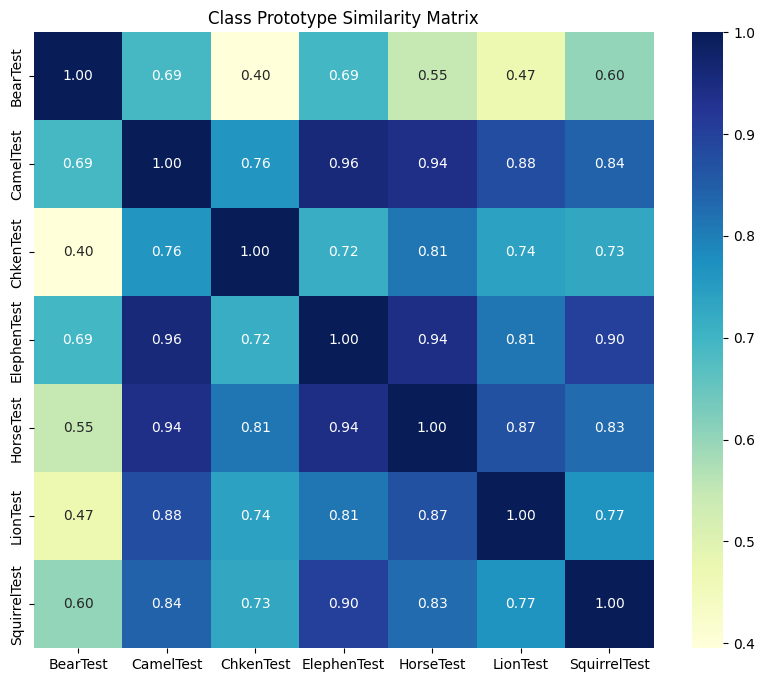

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate class prototype similarity
class_prototypes = []
for class_idx in range(len(class_names)):
    class_feats = features[true_labels == class_idx]
    prototype = class_feats.mean(axis=0)
    class_prototypes.append(prototype)

similarity_matrix = np.zeros((len(class_names), len(class_names)))
for i in range(len(class_names)):
    for j in range(len(class_names)):
        similarity_matrix[i,j] = cosine_similarity(
            class_prototypes[i].reshape(1,-1),
            class_prototypes[j].reshape(1,-1)
        )

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap='YlGnBu',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Class Prototype Similarity Matrix')
plt.show()

## EVALUATION

In [21]:
import time
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [22]:
# Load saved model
model = CustomCNN(num_classes=7).to(device)
model.load_state_dict(torch.load("improved_model.pth"))
model.eval()

CustomCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AdaptiveAvgPool2d(output_size=1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=7, bias=True

Metric          | Value     
----------------------------
Accuracy        | 0.8000
F1 Score        | 0.7977
Precision       | 0.8041
Recall          | 0.8000
Inference Time  | 0.0005s/img
FPS             | 1853.8


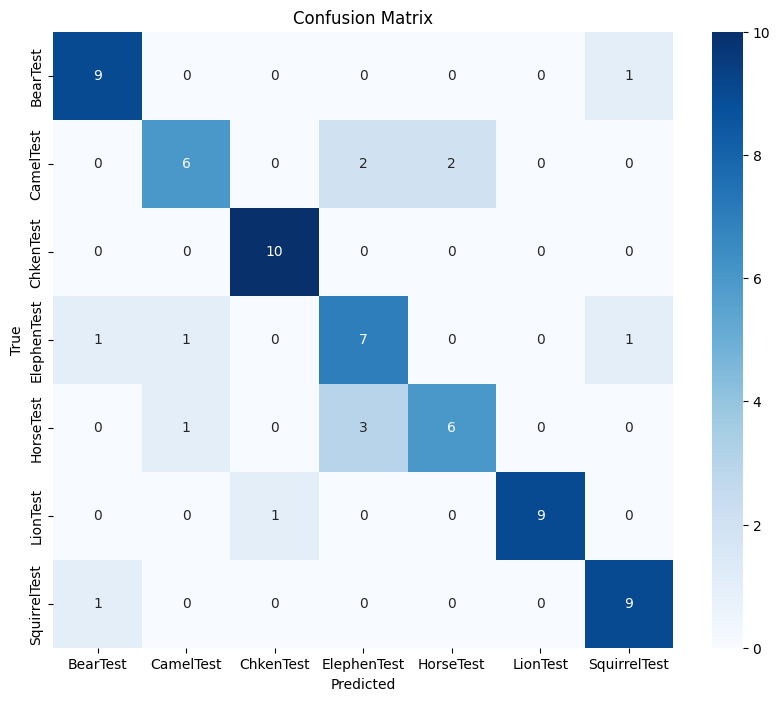

In [23]:
# Evaluation variables
all_preds = []
all_labels = []
total_time = 0

# Main evaluation loop
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Measure inference time
        start_time = time.time()
        outputs = model(images)
        torch.cuda.synchronize()  # For accurate GPU timing
        total_time += time.time() - start_time
        
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

# Calculate speed metrics
avg_inference_time = total_time / len(test_loader.dataset)
fps = 1 / avg_inference_time

# Print results in simple table
print(f"{'Metric':<15} | {'Value':<10}")
print("----------------------------")
print(f"{'Accuracy':<15} | {accuracy:.4f}")
print(f"{'F1 Score':<15} | {f1:.4f}")
print(f"{'Precision':<15} | {precision:.4f}")
print(f"{'Recall':<15} | {recall:.4f}")
print(f"{'Inference Time':<15} | {avg_inference_time:.4f}s/img")
print(f"{'FPS':<15} | {fps:.1f}")

# Show confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=test_dataset.classes,
           yticklabels=test_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Class-wise Performance:
Class           Accuracy   Errors    
BearTest        90.00%     1         
CamelTest       60.00%     4         
ChkenTest       100.00%    0         
ElephenTest     70.00%     3         
HorseTest       60.00%     4         
LionTest        90.00%     1         
SquirrelTest    90.00%     1         


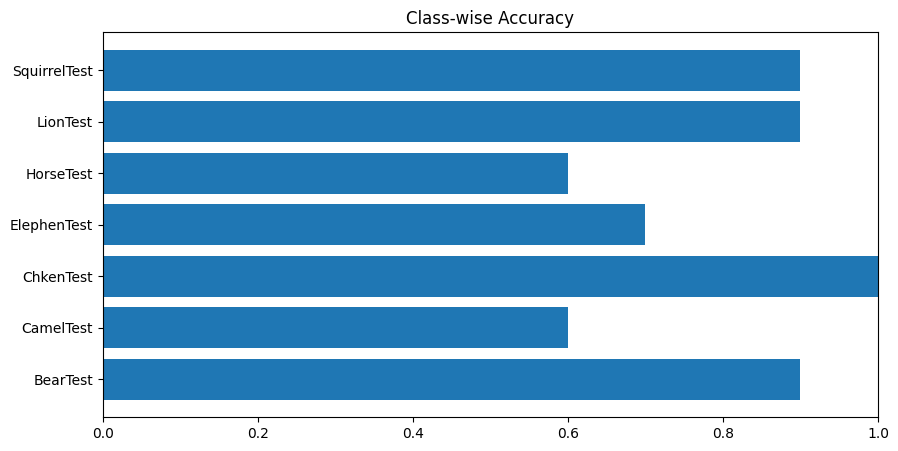

In [24]:
# Add after confusion matrix
class_acc = cm.diagonal() / cm.sum(axis=1)
error_counts = cm.sum(axis=1) - cm.diagonal()

print("\nClass-wise Performance:")
print(f"{'Class':<15} {'Accuracy':<10} {'Errors':<10}")
for i, class_name in enumerate(test_dataset.classes):
    print(f"{class_name:<15} {class_acc[i]:<10.2%} {error_counts[i]:<10}")

# Visualize class accuracy
plt.figure(figsize=(10,5))
plt.barh(test_dataset.classes, class_acc)
plt.title('Class-wise Accuracy')
plt.xlim(0, 1)
plt.show()

In [25]:
# Add after FPS calculation
param_size = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024**2)
print(f"{'Model Size':<15} | {param_size:.2f} MB")

# Peak memory usage during inference
torch.cuda.reset_peak_memory_stats()
_ = model(torch.randn(1, 3, 224, 224).to(device))
print(f"{'GPU Memory':<15} | {torch.cuda.max_memory_allocated()/(1024**2):.1f} MB")

Model Size      | 1.93 MB
GPU Memory      | 120.8 MB


In [26]:
# Add after confusion matrix
top_errors = {}
for i in range(len(test_dataset.classes)):
    for j in range(len(test_dataset.classes)):
        if i != j and cm[i,j] > 0:
            top_errors[f"{test_dataset.classes[i]}→{test_dataset.classes[j]}"] = cm[i,j]

# Show top 5 most common errors
print("\nTop 5 Misclassifications:")
for error, count in sorted(top_errors.items(), key=lambda x: -x[1])[:5]:
    print(f"{error:<20} {count}")


Top 5 Misclassifications:
HorseTest→ElephenTest 3
CamelTest→ElephenTest 2
CamelTest→HorseTest  2
BearTest→SquirrelTest 1
ElephenTest→BearTest 1


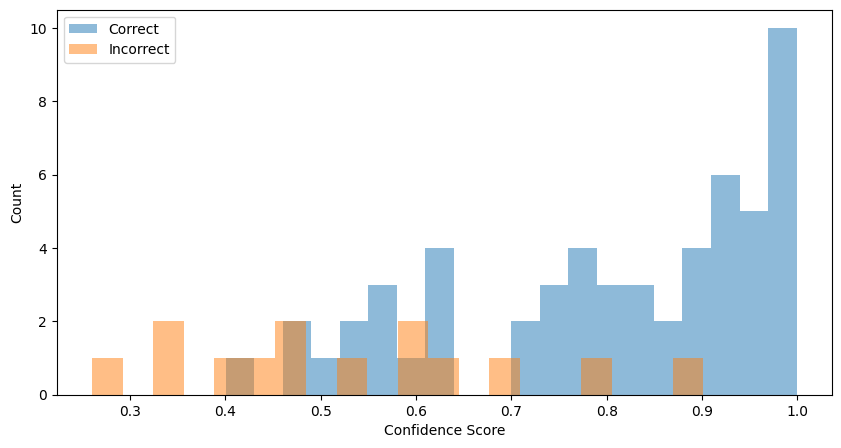

In [27]:
# Add inside the evaluation loop
confidences = []
correct = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        confidences.extend(probs.max(1)[0].cpu().numpy())
        correct.extend((probs.argmax(1) == labels).cpu().numpy())

# Plot confidence histogram
plt.figure(figsize=(10,5))
plt.hist([c for c, r in zip(confidences, correct) if r], 
         bins=20, alpha=0.5, label='Correct')
plt.hist([c for c, r in zip(confidences, correct) if not r], 
         bins=20, alpha=0.5, label='Incorrect')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.legend()
plt.show()

In [28]:
# Add at end (quick rotation test)
from torchvision.transforms.functional import rotate

rotated_acc = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        # Rotate images 15 degrees
        rotated_images = torch.stack([rotate(img, 15) for img in images]).to(device)
        outputs = model(rotated_images)
        rotated_acc += (outputs.argmax(1) == labels.to(device)).sum().item()
        total += labels.size(0)

print(f"\nRotated (15°) Accuracy: {rotated_acc/total:.2%}")


Rotated (15°) Accuracy: 78.57%
